In [45]:
#This is a continuation of the makemore names generator we made previously. As we found in the last study, the counting bigrams method gave similar results as the simple 1 layer nerual net,
# but we found that it would be incredibly hard to scale. Going from 1 character input to 2 character inputs would increase the possibilities from 27 to 27*27. If we had 3 characters,
# it would be 27*27*27, where n-character inputs is 27^n possibilities. Not only would this map be too large to handle, the normalized counts would all go to 0.

# Thankfully, we found a different approach. The neural network model is much easier to handle. Let's build out a more serious version of the net from the last study. For this, we will
# reference Bengio et al in their paper "A Neural Probabilistic Language Model". It's outdated technology, but a huge step forward in our journey towards name generation.

#https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

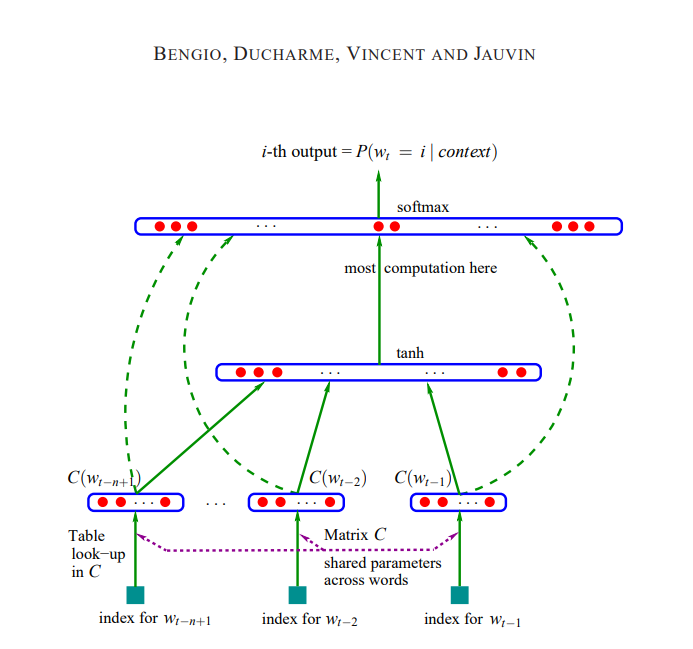

In the figure above, we have 3 input words as the teal boxes and we are attempting to generate 1 output word. Bengio et al has a vocabulary of 17,000 words, so the inputs are an integer
between 0 - 16,999, which represents a word. There is also an embeddings matrix C that is shared for all words. This matrix acts as a look-up table for all the words. It's 17,000 x 30, 
so if you feed in your integer,the embeddings matrix C will pluck out that integer's row and give you the 30-dim vector that represents your word in the vector space. The layer above all the teal boxes shows the 30-dim vectors for the 3 words. You can think of each of the 30-dimensions as a neuron, so we have 90 neurons total. The next layer is called the 'hidden layer', which
is a hyp-parameter. A hyper parameter is up to the designer of the neural net to decide on its size. It can be as big or small as we like, 100 neurons for example. We can choose different
sizes for this parameter and evaluate how well each size works. This is a fully connected layer, meaning all neurons in this layer connect to each of the 90 neurons from the embedding layer below. We through in a tanh non-linearity for scaling purposes. The next layer up is the largest. It has 17,000 neurons, each one representing a word from our vocabulary. Throw in a softmax to get a nice normalized distribution. Finally we get the output layer of a single integer which represents some word. 

During training, we know what the output is, so we can select that probability output and maximize it through gradient descent (see autograd study) with respect to the parameters. Our parameters are the weights and biases of each layer in this neural net (anywhere you see red dots in the picture). We will ignore the dashed arrows for now.

In [46]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [47]:
len(words)

32033

In [48]:
#build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [109]:
# Now lets build our dataset to train on. A clever way to do this is not to hardcode bigrams (like the last version), but make the input size variable. We will call this block_size

block_size = 3
X, Y = [], [] # X will be our context indices and Y will be the following index from the context. Think of Y as the target given the context X.
for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [50]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [110]:
X.shape, X.dtype

(torch.Size([228146, 3]), torch.int64)

In [52]:
#In the Bengio et al paper, they have a  vocabulary of 17,000 words, and build vectors that represent those words in a 30-dimensional space. Since we are working with characters, we have 27.
# Let's try to fit them in a 2-dimensional space as a start. The paper refers to the parameter matrix as 'C', so we will re-use that.

C = torch.randn((27,2)) #row x column (27 x 2)

In [53]:
# Let's try an example of calling a value from the tensor. If we want the 5th row, we can simply write
C[5]

tensor([-1.2758,  0.8034])

In [54]:
# Last time we were using one-hot encoding. This takes the full C tensor and multiplies by a column vector of all 0s except that the 5th value is turned on (is a 1). This means
# all parts of C are multiplied by 0 except the fifth row which is multiplied by 1. This 'plucks out' the fifth C row.

F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-1.2758,  0.8034])

In [55]:
# Instead of doing all this multiplication, lets stick with the index notation. We can actually pull multiple values from C using lists or even tensors!
C[torch.tensor([4,5,6,7,7,7])]

tensor([[ 1.3383,  0.7341],
        [-1.2758,  0.8034],
        [-0.8198, -1.6910],
        [-1.6203,  0.3680],
        [-1.6203,  0.3680],
        [-1.6203,  0.3680]])

In [56]:
# Ok this will blow your mind. You can feed in a 2 dimensional tensor to C and receive back a 3 dimensional tensor!! 0.0
C[X]


tensor([[[ 1.0595,  0.5117],
         [ 1.0595,  0.5117],
         [ 1.0595,  0.5117]],

        [[ 1.0595,  0.5117],
         [ 1.0595,  0.5117],
         [-1.2758,  0.8034]],

        [[ 1.0595,  0.5117],
         [-1.2758,  0.8034],
         [ 0.5071,  0.5811]],

        [[-1.2758,  0.8034],
         [ 0.5071,  0.5811],
         [ 0.5071,  0.5811]],

        [[ 0.5071,  0.5811],
         [ 0.5071,  0.5811],
         [ 0.4694,  0.3168]],

        [[ 1.0595,  0.5117],
         [ 1.0595,  0.5117],
         [ 1.0595,  0.5117]],

        [[ 1.0595,  0.5117],
         [ 1.0595,  0.5117],
         [ 0.8586,  0.8678]],

        [[ 1.0595,  0.5117],
         [ 0.8586,  0.8678],
         [-1.4026, -1.1995]],

        [[ 0.8586,  0.8678],
         [-1.4026, -1.1995],
         [ 0.2591, -0.1585]],

        [[-1.4026, -1.1995],
         [ 0.2591, -0.1585],
         [ 1.2197, -0.3856]],

        [[ 0.2591, -0.1585],
         [ 1.2197, -0.3856],
         [ 0.2591, -0.1585]],

        [[ 1.2197, -0

In [57]:
X[13,2] # 2nd dimension in the 13th row

tensor(1)

In [58]:
C[X][13,2]

tensor([0.4694, 0.3168])

In [59]:
C[1]

tensor([0.4694, 0.3168])

In [60]:
# This is our embedding matrix C
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [61]:
# Now lets make the 2nd layer from the picture, the 'hidden layer'
W1 = torch.randn((6, 100)) # 6 inputs because we have 2-dim embeddings, and we have 3 characters. We can use 100 neurons as an example.
b1 = torch.randn(100) 

In [66]:
# We want to do something like the equation below, but our matrices are not dimensioned correctly for multiplication. Thankfully PyTorch is awesome and gives us a function to concatenate 
# matrices
# emb @ W1 + b1

In [63]:
# We want to take the [32, 3, 2] matrix and combine the last 2 dimensions so it turns into [32, 6]. Then we can multiply. In other words, we want to take the [32,2] embedding for each of the 
# 3 words and put the vectors into a single matrix, not 3 separate matrices.

# This does the trick, but it doesn't scale. This example only works for 3 character inputs, but what if we want more later?
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1)

tensor([[ 1.0595,  0.5117,  1.0595,  0.5117,  1.0595,  0.5117],
        [ 1.0595,  0.5117,  1.0595,  0.5117, -1.2758,  0.8034],
        [ 1.0595,  0.5117, -1.2758,  0.8034,  0.5071,  0.5811],
        [-1.2758,  0.8034,  0.5071,  0.5811,  0.5071,  0.5811],
        [ 0.5071,  0.5811,  0.5071,  0.5811,  0.4694,  0.3168],
        [ 1.0595,  0.5117,  1.0595,  0.5117,  1.0595,  0.5117],
        [ 1.0595,  0.5117,  1.0595,  0.5117,  0.8586,  0.8678],
        [ 1.0595,  0.5117,  0.8586,  0.8678, -1.4026, -1.1995],
        [ 0.8586,  0.8678, -1.4026, -1.1995,  0.2591, -0.1585],
        [-1.4026, -1.1995,  0.2591, -0.1585,  1.2197, -0.3856],
        [ 0.2591, -0.1585,  1.2197, -0.3856,  0.2591, -0.1585],
        [ 1.2197, -0.3856,  0.2591, -0.1585,  0.4694,  0.3168],
        [ 1.0595,  0.5117,  1.0595,  0.5117,  1.0595,  0.5117],
        [ 1.0595,  0.5117,  1.0595,  0.5117,  0.4694,  0.3168],
        [ 1.0595,  0.5117,  0.4694,  0.3168,  1.2197, -0.3856],
        [ 0.4694,  0.3168,  1.2197, -0.3

In [64]:
# Pytorch saves the day again with the unbind function. It returns a tuple of all slices along a given dimension. Think of it as pulling out and returning a dimension of a matrix.
torch.cat(torch.unbind(emb, 1), 1)

tensor([[ 1.0595,  0.5117,  1.0595,  0.5117,  1.0595,  0.5117],
        [ 1.0595,  0.5117,  1.0595,  0.5117, -1.2758,  0.8034],
        [ 1.0595,  0.5117, -1.2758,  0.8034,  0.5071,  0.5811],
        [-1.2758,  0.8034,  0.5071,  0.5811,  0.5071,  0.5811],
        [ 0.5071,  0.5811,  0.5071,  0.5811,  0.4694,  0.3168],
        [ 1.0595,  0.5117,  1.0595,  0.5117,  1.0595,  0.5117],
        [ 1.0595,  0.5117,  1.0595,  0.5117,  0.8586,  0.8678],
        [ 1.0595,  0.5117,  0.8586,  0.8678, -1.4026, -1.1995],
        [ 0.8586,  0.8678, -1.4026, -1.1995,  0.2591, -0.1585],
        [-1.4026, -1.1995,  0.2591, -0.1585,  1.2197, -0.3856],
        [ 0.2591, -0.1585,  1.2197, -0.3856,  0.2591, -0.1585],
        [ 1.2197, -0.3856,  0.2591, -0.1585,  0.4694,  0.3168],
        [ 1.0595,  0.5117,  1.0595,  0.5117,  1.0595,  0.5117],
        [ 1.0595,  0.5117,  1.0595,  0.5117,  0.4694,  0.3168],
        [ 1.0595,  0.5117,  0.4694,  0.3168,  1.2197, -0.3856],
        [ 0.4694,  0.3168,  1.2197, -0.3

In [65]:
# However, there is a better way to do this
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [67]:
a.shape

torch.Size([18])

In [68]:
a.view(2,9)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [69]:
# The key here is understanding how Pytorch stores vector information in your memory. It is always a 1-dimensional array, and the view function doesn't re-arrange any of the data. Nothing
# is moved, changed, or deleted, so it is very efficient.
a.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [70]:
emb.view(32,6) == torch.cat(torch.unbind(emb, 1), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [71]:
# Going all the way back to multiplication of emb and W1, we can just do the following
# Using -1 is a way of telling Pytorch to infer what the size should be. Saying the 2nd dim is 6, the first must be 32 (or anything else for different inputs)
# Also, the broadcasting of b1 is correct. Make sure to always check
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
h

tensor([[ 0.9969,  0.9993,  0.1784,  ...,  0.4773,  0.9982,  0.1230],
        [ 0.9985, -0.7474,  0.9086,  ...,  0.8065,  0.9999, -0.7295],
        [ 0.9823,  0.9767,  0.8248,  ..., -0.0934,  0.9977,  0.3840],
        ...,
        [-0.8315,  0.2242,  1.0000,  ..., -0.9992,  0.9977,  0.9733],
        [ 1.0000,  0.9642, -0.9999,  ...,  0.9998,  0.2725, -0.7137],
        [-0.7232,  0.9956,  0.9955,  ..., -0.2808,  0.9995, -0.4374]])

In [72]:
# We know have 100 neurons for each of the 32 examples of X
h.shape

torch.Size([32, 100])

In [73]:
# Ok next layer of 17,000 neurons, but only 27 for us =)
W2 = torch.randn((100, 27)) # 100 neurons input from the hidden layer, 27 output for each character
b2 = torch.randn(27)

In [74]:
logits = h @ W2 + b2

In [75]:
logits.shape

torch.Size([32, 27])

In [76]:
counts = logits.exp()

In [77]:
prob = counts / counts.sum(1, keepdims=True)

In [78]:
prob.shape

torch.Size([32, 27])

In [80]:
prob[0].sum()

tensor(1.)

In [82]:
# Final layer, outputs. This is Y that we created at the beginning
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [87]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.1568)

In [ ]:
# Let's re-write all of this to make it neater

In [117]:
X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [160]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [161]:
sum(p.nelement() for p in parameters) # total number of parameters

3481

In [162]:
for p in parameters:
    p.requires_grad = True

In [122]:
for _ in range(10):
    #forward pass
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100)
    logits = h @ W2 + b2 # (32,27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits,Y) # I hate to break it to you, but taking the logits and converting into a loss is not a new concept =( PyTorch has a function that will do this for us.
    print(loss.item())
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    for p in parameters:
        p.data += -0.1 * p.grad


10.709587097167969
10.407631874084473
10.127808570861816
9.864364624023438
9.614503860473633
9.376439094543457
9.148944854736328
8.931111335754395
8.7222318649292
8.521749496459961


In [108]:
# That's a more respectable loss value! Remeber our old loss value from the bigram neural net was around 2.45. Keep in mind that this is only the first 5 names, and we are using tons of 
# parameters. We are overfitting this data.

# We can't fully over-fit. In our names, the first example is ..., with the Y output being the first letter of the name. In our example, ... is followed by an e in emma, o in olivia
# a in ava, i in isabella, and s in sophia. So 1 input maps to 5 different outputs. This is why the loss can't reach 0.

In [106]:
logits.max(1)

torch.return_types.max(
values=tensor([13.4137, 17.9643, 20.6772, 20.7269, 16.8571, 13.4137, 16.1145, 14.2717,
        16.0138, 18.5008, 16.0737, 21.0530, 13.4137, 17.2579, 17.2660, 20.2017,
        13.4137, 16.7055, 15.2577, 17.2022, 18.6940, 16.1056, 10.9961, 10.7942,
        15.5882, 13.4137, 16.2898, 17.0881, 12.8240, 16.2914, 19.2257, 16.1886],
       grad_fn=<MaxBackward0>),
indices=tensor([19, 13, 13,  1,  0, 19, 12,  9, 22,  9,  1,  0, 19, 22,  1,  0, 19, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [107]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [124]:
# At this point I went back to add all the names to the training set, not just the first 5. It takes a while to do the forward and backward pass for the whole data set. Let's improve this
# We can instead take a mini-batch of data, perform the forward and backwards pass, then iterate over the whole data set
torch.randint(0, X.shape[0], (32,))

tensor([169782, 116808, 100978, 223377,  85569, 218777, 143460,  76981,  71375,
          8606,  72970, 135355,  79894,  35357,  97164,  44780, 126149,  61287,
         33130,  10294,  46905, 165103, 220577, 158077, 157655, 145202,  81736,
        152308, 157355, 226599, 215549,   1906])

In [144]:
# While this is faster, we are only doing the forward and backwards pass for part of the dataset. This means the gradient is only being updated for parts of the dataset, so the 
# 'quality' of the gradient is lower. Think of this as the approximate gradient since only some of it is up to date. In practice we find that we can reach a lower loss faster 
# by descending down the approximate gradient rather than calculating the entire 'correct' gradient and then descending. Neat!

for _ in range(100):

    #mini batch construct
    ix = torch.randint(0, X.shape[0], (32,))

    #forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100)
    logits = h @ W2 + b2 # (32,27)
    loss = F.cross_entropy(logits,Y[ix])
    print(loss.item()) 
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    for p in parameters:
        p.data += -0.1 * p.grad
print(loss.item())

19.38861846923828
17.519939422607422
16.39991569519043
15.232988357543945
13.96699047088623
15.571447372436523
14.326784133911133
13.07502555847168
12.76171875
11.070860862731934
9.549388885498047
8.67146110534668
10.648767471313477
8.871011734008789
11.437601089477539
9.317160606384277
11.737574577331543
9.432838439941406
6.4898858070373535
7.653731822967529
10.240166664123535
9.57028865814209
7.008874416351318
8.078784942626953
6.701690196990967
6.720768928527832
9.174574851989746
7.778417587280273
8.429661750793457
8.395795822143555
7.185415267944336
9.405649185180664
5.85334587097168
7.564177513122559
6.59163761138916
6.592428684234619
7.223940849304199
6.98518705368042
4.876723766326904
6.680586338043213
5.9296417236328125
7.090760231018066
5.611185073852539
6.497908115386963
4.847771644592285
4.760319709777832
4.87499475479126
5.784759521484375
5.775570392608643
4.996516704559326
3.867936849594116
5.594119548797607
4.979341506958008
4.610790252685547
6.684051513671875
4.938405036

In [134]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100)
logits = h @ W2 + b2 # (32,27)
loss = F.cross_entropy(logits,Y)
loss 

tensor(2.6455, grad_fn=<NllLossBackward0>)

In [148]:
# Something to consider is the 'learning rate'. How fast should we jump down the gradient? We started with -0.1, but that was just a guess. Surely there is an optimal 'speed'. Just
# from playing around with it, its probably somewhere between -1 and -0.001.
lre = torch.linspace(-3, 0, 1000) # learning rate exponent
lrs = 10**lre # learning rates
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [163]:
lri = []
lossi = [] 

for i in range(1000):

    #mini batch construct
    ix = torch.randint(0, X.shape[0], (32,))

    #forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100)
    logits = h @ W2 + b2 # (32,27)
    loss = F.cross_entropy(logits,Y[ix])
    print(loss.item()) 

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    lri.append(lre[i])
    lossi.append(loss.item())    

#print(loss.item())

18.431669235229492
18.94832992553711
20.25430679321289
19.945871353149414
16.1593017578125
21.494064331054688
18.253639221191406
17.882495880126953
19.01937484741211
20.731718063354492
15.74424934387207
18.7905330657959
21.700590133666992
22.61521339416504
19.647294998168945
19.96373176574707
17.464284896850586
19.60506820678711
23.272729873657227
18.688488006591797
18.53801918029785
16.59810447692871
19.644128799438477
17.251174926757812
18.665685653686523
16.833820343017578
17.95124626159668
18.292062759399414
18.122861862182617
20.965190887451172
14.64927864074707
19.89898109436035
18.688867568969727
20.264575958251953
19.661418914794922
18.75910758972168
18.616680145263672
18.305553436279297
19.68011474609375
19.70035743713379
17.649581909179688
19.330528259277344
18.83249855041504
17.672054290771484
15.411307334899902
15.366142272949219
19.226154327392578
18.869606018066406
20.017986297607422
16.247201919555664
17.25161361694336
20.347339630126953
17.47832679748535
16.186054229736

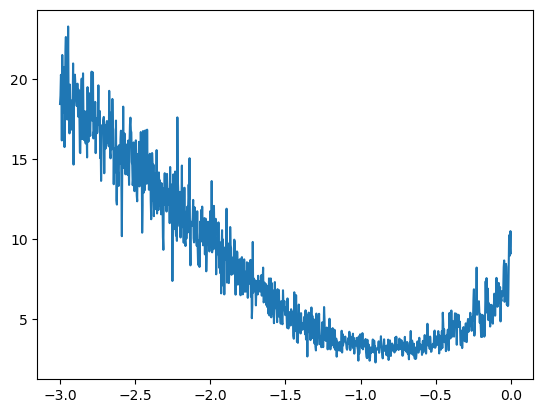

In [164]:
# How cool is this! This shows our loss across the scan of learning rate exponents. We see the optimal is around -0.9
plt.plot(lri, lossi)

In [168]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [173]:
#Now lets use that optimal lr
lri = []
lossi = [] 

for i in range(10000):

    #mini batch construct
    ix = torch.randint(0, X.shape[0], (32,))

    #forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100)
    logits = h @ W2 + b2 # (32,27)
    loss = F.cross_entropy(logits,Y[ix])
    #print(loss.item()) 

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.09
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())    

#print(loss.item())

In [174]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100)
logits = h @ W2 + b2 # (32,27)
loss = F.cross_entropy(logits,Y)
loss 

tensor(2.3386, grad_fn=<NllLossBackward0>)

In [175]:
# bigram was 2.45 and this is around 2.30. Progress! Now let's step back and be careful. We want to avoid over-fitting the model. This means that the model is basically just memorizing
# the data and doesn't create anything new. When you give an input, it simply returns an output that is already in the data set. This would not be a good model.
# To avoid this, it is common to split your data into 3 separate 'splits'. We have the training split, the dev split (or the validation split), and the test split. Roughly speaking, this
# is an 80/10/10 % split acorss the 3, respectively. 

# The training split is used to optimize the parameters of your model using gradient descent, like we have been doing this whole time.
# The dev split is used for the development of your hyper-parameters in your model. For example, the 100 neurons in the hidden layer, or the 2-dimensions in the emb matrix C.
# The test split is used to evaluate the performance of the model at the end. Don't evaluate your loss too often using this set, because you run the risk of over-fitting to this split.

# Let's build the datasets
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) #training split
Xdev, Ydev = build_dataset(words[n1:n2]) #dev split
Xte, Yte = build_dataset(words[n2:]) #test split

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [176]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [177]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [181]:
lri = []
lossi = [] 

for i in range(30000):

    #mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    #forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100)
    logits = h @ W2 + b2 # (32,27)
    loss = F.cross_entropy(logits,Ytr[ix])
    #print(loss.item()) 

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.09
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())    

print(loss.item())

2.060741424560547


In [182]:
# So we have trained the model on the training set. Now lets evaluate on the dev set. Notice we now have 2 loss values, one for each set. The model has never seen the dev set. 
# Even so, the loss on the dev set is pretty low, 2.32 
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100)
logits = h @ W2 + b2 # (32,27)
loss = F.cross_entropy(logits,Ydev)
loss 

tensor(2.3259, grad_fn=<NllLossBackward0>)

In [183]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100)
logits = h @ W2 + b2 # (32,27)
loss = F.cross_entropy(logits,Ytr)
loss 

tensor(2.3271, grad_fn=<NllLossBackward0>)

In [222]:
#Since the training set and dev set are similar is loss, this tells us we have not over-fit the model. Now, scaling the number of parameters should lead to better performance. Lets do that.
# We will bump the hidden layer up to 300 neurons

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [223]:
sum(p.nelement() for p in parameters) # total number of parameters

11897

In [224]:
lri = []
lossi = []
stepi = [] 

In [225]:
for i in range(200000):

    #mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    #forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32,100)
    logits = h @ W2 + b2 # (32,27)
    loss = F.cross_entropy(logits,Ytr[ix])
    #print(loss.item()) 

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())    

#print(loss.item())

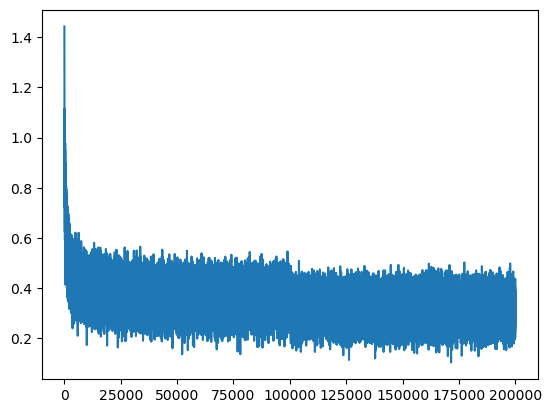

In [226]:
plt.plot(stepi, lossi) # Note the fuzziness. This is due to the fact that we are optimizing in mini batches. This could be a bottle-neck to the models performance.

In [227]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32,100)
logits = h @ W2 + b2 # (32,27)
loss = F.cross_entropy(logits,Ydev)
loss 

tensor(2.1624, grad_fn=<NllLossBackward0>)

In [228]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32,100)
logits = h @ W2 + b2 # (32,27)
loss = F.cross_entropy(logits,Ytr)
loss 

tensor(2.1157, grad_fn=<NllLossBackward0>)

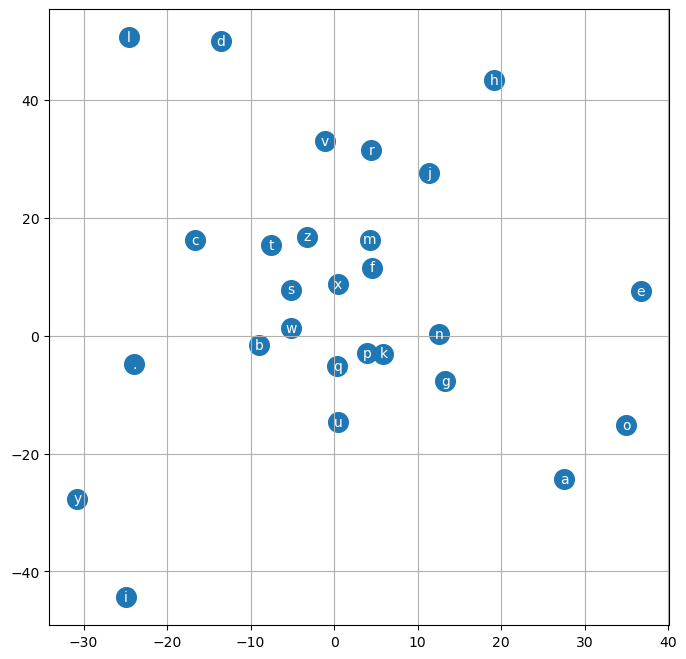

In [206]:
# Another bottleneck could be that we are only using 2 dimensions in the embedding space. Let's first visualize, then add more dimensions. Remember that bengio et al used 30.
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
# Letters that are close together are interpretted as 'similar' to the model.
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')